# Vision Transformer
#### tensorflow==2.18.0

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Add, Reshape, Input, LayerNormalization, MultiHeadAttention, Embedding, GlobalAveragePooling1D

In [12]:
train_dir = r"C:\Users\91909\Desktop\ML\DATA\PlantVillage-Dataset-master\PlantVillage-Dataset-master\raw\PLANT_VILLAGE_SPLIT\train"
test_dir = r"C:\Users\91909\Desktop\ML\DATA\PlantVillage-Dataset-master\PlantVillage-Dataset-master\raw\PLANT_VILLAGE_SPLIT\test"
val_dir = r"C:\Users\91909\Desktop\ML\DATA\PlantVillage-Dataset-master\PlantVillage-Dataset-master\raw\PLANT_VILLAGE_SPLIT\val"

In [13]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

In [14]:
def preprocess_function(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image

In [15]:
datagen = ImageDataGenerator(rescale=1.0/255,
                             preprocessing_function=preprocess_function)

In [16]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 32572 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Found 10885 images belonging to 38 classes.


In [5]:
IMAGE_SIZE = 224
PATCH_SIZE = 16
NUM_CLASSES = 38
D_MODEL = 64
NUM_HEADS = 4
NUM_LAYERS = 6

def create_patch_embedding():
    return keras.Sequential([
        Conv2D(D_MODEL, kernel_size=PATCH_SIZE, strides=PATCH_SIZE, padding='valid'),
        Reshape((-1, D_MODEL)),
    ])

def transformer_block():
    inputs = Input(shape=(None, D_MODEL))
    x = LayerNormalization()(inputs)
    x = MultiHeadAttention(NUM_HEADS, key_dim=D_MODEL)(x, x)
    x = Add()([inputs, x])
    x_skip = LayerNormalization()(x)
    x = Dense(D_MODEL, activation='gelu')(x_skip)
    x = Add()([x_skip, x])
    return keras.Model(inputs, x)

def vit():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = create_patch_embedding()(inputs)
    x += Embedding(input_dim=x.shape[1], output_dim=D_MODEL)(tf.range(x.shape[1]))
    for _ in range(NUM_LAYERS):
        x = transformer_block()(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return keras.Model(inputs, outputs)

model = vit()

In [59]:
model.compile(tf.keras.optimizers.Adam(learning_rate = 0.001), # Learning rate of 0.001 was set after test training multiple times with different values
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [60]:
model.build(input_shape=(None, 224, 224, 3))

In [61]:
model.summary()

Model: "functional_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_6 (Sequential)            │ (None, 196, 64)             │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add_39 (Add)                         │ (None, 196, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_62 (Functional)           │ (None, 196, 64)             │          70,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_63 (Functional)           │ (None, 196, 64)             │          70,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_64 (Functional)           │ (None, 196, 64)             │          70,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_65 (Functional)           │ (None, 196, 64)             │          70,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_66 (Functional)           │ (None, 196, 64)             │          70,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_67 (Functional)           │ (None, 196, 64)             │          70,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 38)                  │           2,470 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 476,390 (1.82 MB)

 Trainable params: 476,390 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5, restore_best_weights=True) # min_delta was chosen 0.005 after multiple testing with different values

In [63]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 198s 86ms/step - accuracy: 0.2797 - loss: 2.6124 - val_accuracy: 0.6414 - val_loss: 1.1717
Epoch 2/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 154s 76ms/step - accuracy: 0.6718 - loss: 1.0559 - val_accuracy: 0.7632 - val_loss: 0.7761
Epoch 3/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 158s 77ms/step - accuracy: 0.7620 - loss: 0.7598 - val_accuracy: 0.8081 - val_loss: 0.6232
Epoch 4/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 154s 75ms/step - accuracy: 0.8105 - loss: 0.5970 - val_accuracy: 0.8039 - val_loss: 0.6227
Epoch 5/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 167s 82ms/step - accuracy: 0.8350 - loss: 0.5272 - val_accuracy: 0.8488 - val_loss: 0.4799
Epoch 6/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 189s 76ms/step - accuracy: 0.8527 - loss: 0.4504 - val_accuracy: 0.8487 - val_loss: 0.4886
Epoch 7/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 164s 80ms/step - accuracy: 0.8642 - loss: 0.4106 - val_accuracy: 0.8645 - val_loss: 0.4334
Epoch 8/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 150s 74ms/step - accuracy: 

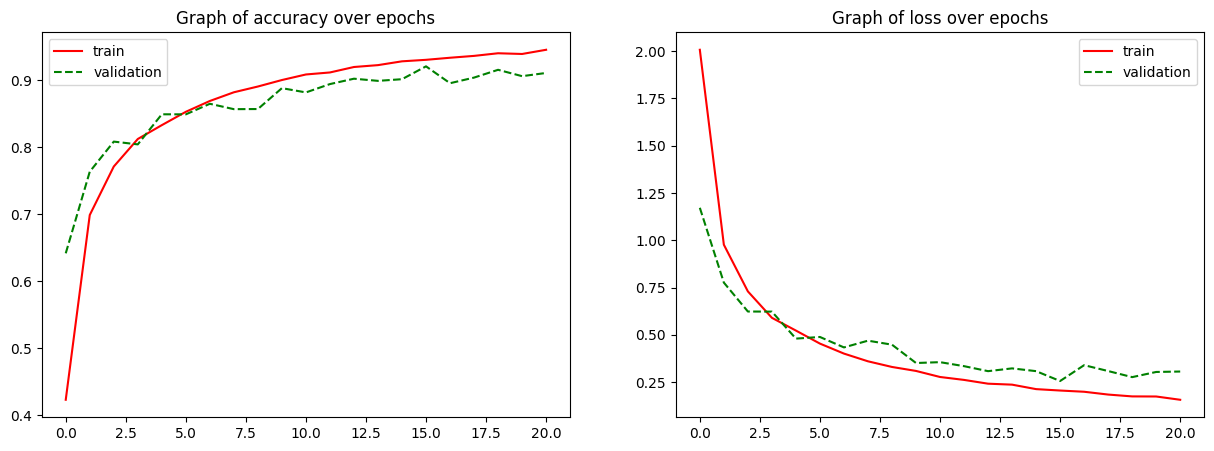

In [64]:
def printplot(history):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["accuracy"], color="red", label="train")
        plt.plot(history.history["val_accuracy"], color="green", label="validation", linestyle="dashed")
        plt.title("Graph of accuracy over epochs")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], color="red", label="train")
        plt.plot(history.history["val_loss"], color="green", label="validation", linestyle="dashed")
        plt.title("Graph of loss over epochs")
        plt.legend()

printplot(history)

In [65]:
model.save('ViT.h5')

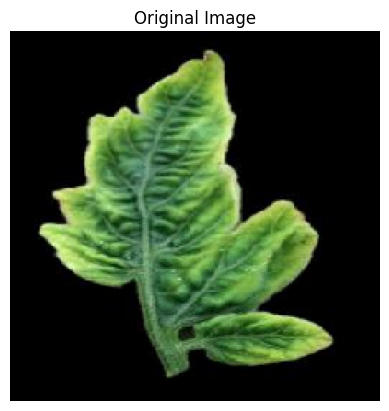

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Actual Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [66]:
images, labels = next(val_generator)

selected_image = images[0]
selected_label = labels[0]

plt.imshow(selected_image)
plt.title("Original Image")
plt.axis('off')
plt.show()

image_for_prediction = np.expand_dims(selected_image, axis=0)

predicted_probs = model.predict(image_for_prediction)
predicted_class = np.argmax(predicted_probs, axis=1)

actual_class = np.argmax(selected_label)

class_names = list(val_generator.class_indices.keys())

predicted_class_name = class_names[predicted_class[0]]
actual_class_name = class_names[actual_class]

print(f"Predicted Class: {predicted_class_name}")
print(f"Actual Class: {actual_class_name}")

In [67]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

681/681 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.9229 - loss: 0.2497
Test Accuracy: 91.88%
Test Loss: 0.2606


In [68]:
from sklearn.metrics import precision_recall_curve, average_precision_score

test_steps = test_generator.samples // BATCH_SIZE + 1
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=test_steps)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = {}
recall = {}
average_precision = {}

for i in range(test_generator.num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred_probs[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_pred_probs[:, i])

681/681 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step


<ipython-input-69-67c8bcb4f8b3>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


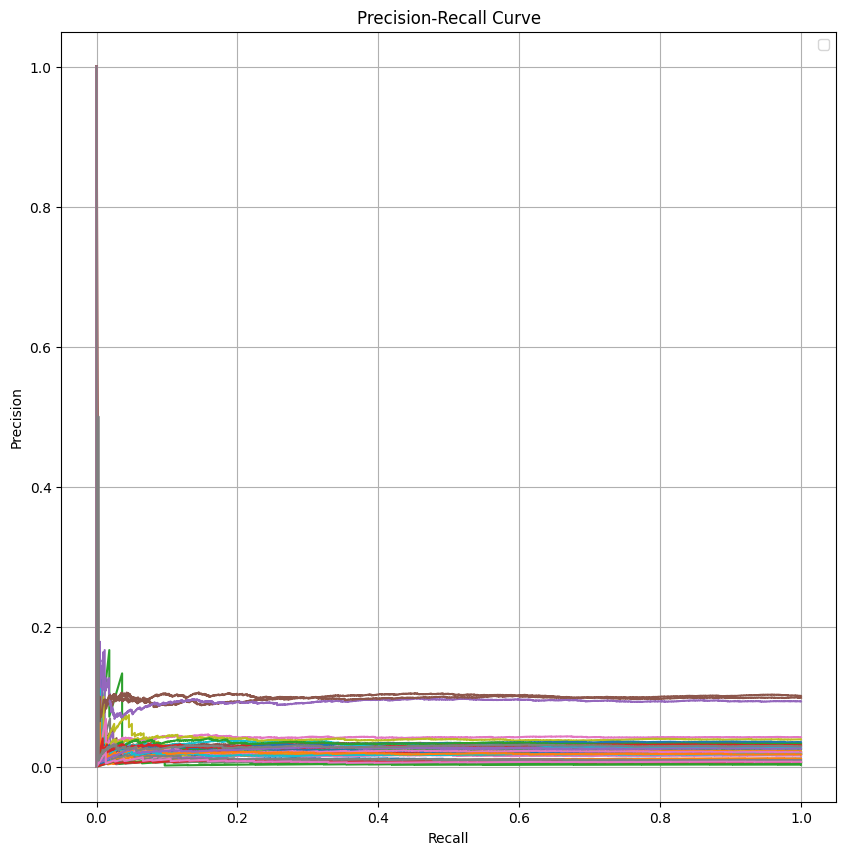

In [69]:
plt.figure(figsize=(10, 10))
for i in range(test_generator.num_classes):
    plt.plot(recall[i], precision[i]) #, label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()